# Sentinel-1 SLC preprocessing + OpenEO custom processes

In [1]:
import openeo

import rasterio
from rasterio.plot import show

import matplotlib.pyplot as plt

In [2]:
url = "https://openeo.dataspace.copernicus.eu"
connection = openeo.connect(url).authenticate_oidc()

Authenticated using refresh token.


## 1) Create a datacube with coregistered Sentinel-1 SLC

In [3]:
slc_datacube = openeo.rest.datacube.DataCube(
    openeo.rest.datacube.PGNode(
        "insar_preprocessing_v02",
        arguments={
            "burst_id": 249435,
            "sub_swath": "IW2",
            "temporal_extent": [
                "2024-08-01",
                "2024-09-02"
            ],
            "master_date": "2024-08-09",
            "polarization": "vh"
        },
    ),
    connection=connection,
)

## 2) Execute custom openEO processes on the SLC datacube

As a simple example it is now showed how to apply openEO processes to the generated slc datacube to compute the amplitude of each slc image. The amplitude ($A$) is computed from the real ($Re$) and imaginary ($Im$) part of the slc as $A = \sqrt{Re^2 + Im^2}$

Compute the amplitude in dB scale

In [4]:
amplitude = (slc_datacube.band("i_VH")**2 + slc_datacube.band("q_VH")**2)**0.5
amplitude_db = amplitude.apply(lambda x: x.log(base=10)) * 10
amplitude_db = amplitude_db.save_result(format="GTiff")
amplitude_db

Create the job and execute it

In [5]:
job = amplitude_db.create_job(
    title="slc_preprocessing_amplitude_db",
    job_options = {"image-name": "registry.stag.waw3-1.openeo-int.v1.dataspace.copernicus.eu/dev/openeo-geotrellis-kube-python311:20250623-41"}
)
job.start_and_wait()

0:00:00 Job 'j-2506251402114368be35ce0cb404f479': send 'start'
0:00:13 Job 'j-2506251402114368be35ce0cb404f479': created (progress 0%)
0:00:18 Job 'j-2506251402114368be35ce0cb404f479': created (progress 0%)
0:00:24 Job 'j-2506251402114368be35ce0cb404f479': created (progress 0%)
0:00:32 Job 'j-2506251402114368be35ce0cb404f479': created (progress 0%)
0:00:42 Job 'j-2506251402114368be35ce0cb404f479': created (progress 0%)
0:00:54 Job 'j-2506251402114368be35ce0cb404f479': created (progress 0%)
0:01:09 Job 'j-2506251402114368be35ce0cb404f479': created (progress 0%)
0:01:29 Job 'j-2506251402114368be35ce0cb404f479': running (progress N/A)
0:01:53 Job 'j-2506251402114368be35ce0cb404f479': running (progress N/A)
0:02:22 Job 'j-2506251402114368be35ce0cb404f479': running (progress N/A)
0:03:00 Job 'j-2506251402114368be35ce0cb404f479': running (progress N/A)
0:03:46 Job 'j-2506251402114368be35ce0cb404f479': running (progress N/A)
0:04:45 Job 'j-2506251402114368be35ce0cb404f479': running (progress 

<BatchJob job_id='j-2506251402114368be35ce0cb404f479'>

Download the result

In [7]:
job.get_results().download_files()

[PosixPath('/home/jovyan/mystorage/ClouDInSAR/openEO_2024-08-09Z.tif'),
 PosixPath('/home/jovyan/mystorage/ClouDInSAR/openEO_2024-08-21Z.tif'),
 PosixPath('/home/jovyan/mystorage/ClouDInSAR/openEO_2024-09-02Z.tif'),
 PosixPath('/home/jovyan/mystorage/ClouDInSAR/job-results.json')]

Visualize one amplitude image from the tif file

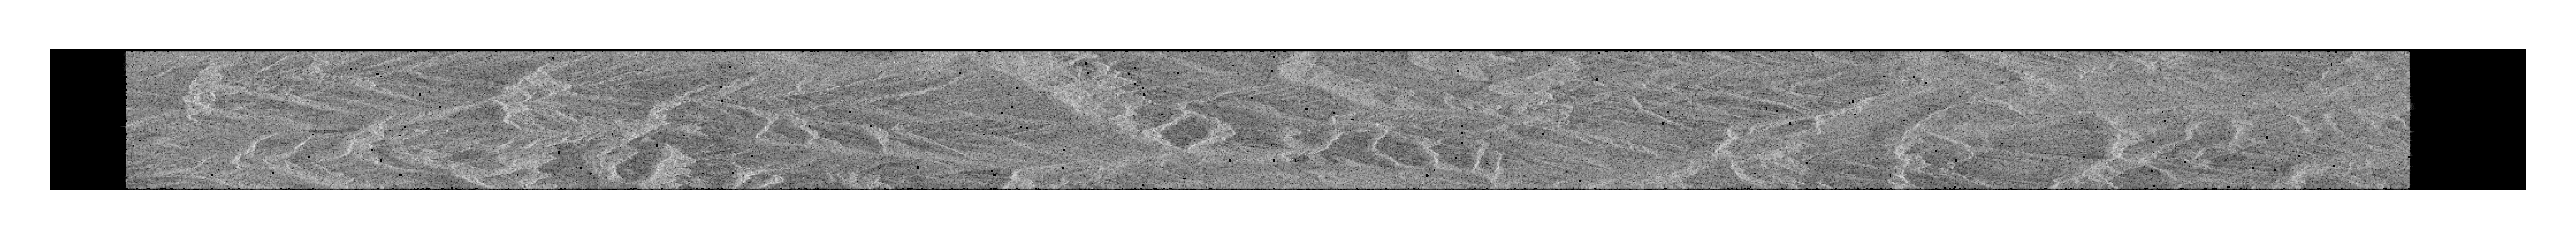

In [17]:
with rasterio.open('openEO_2024-08-21Z.tif') as src:

    # Initialize the figure with a custom dpi
    fig, ax = plt.subplots(dpi=1200)

    # Create a grayscale colormap with black as no data
    cmap = plt.cm.gray
    cmap.set_bad(color='black')

    # Visualize the image
    ax.set_axis_off()
    show(src.read(1), cmap=cmap, ax=ax)